In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import param
import copy

#need to test some of the movements here- model it after what Borna does, with the defined parameters that are then
#used to change the step size

# unit cell parameters in A- this is for the TiO2 (110) suraface. Will neet to change to multiples of the PES.
#not sure why this is included in the simulation. 
unitcell_a = 13.216
unitcell_b = 12.243
unitcell_c = 26.362

# primitive cell parameters in A (used for PES)
primcell_a = 4.84025 #these are the lengths of the a and b vectors- not the coordinates of then in cartesian
primcell_b = 4.84025 #would it be a good idea to add in the angle between the unit cells as well, and make that
                     #something used to walk around on the mesh?
N_mesh = 11*11
meshx = 0.1 #added from Borna's PES code
meshy = 0.1 #added from Borna's PES code
xstep_max  =  primcell_a / 10.0
ystep_max  =  primcell_b / 10.0

Xstep = primcell_a - primcell_b*np.cos(np.deg2rad(60))
Ystep = primcell_b*np.sin(np.deg2rad(60))
#okay, so what's basically happening above here is that it's defining the step_max to be a 10th of the primitive cell
#so what I think I need to do is for the PES_finder for the step, and any cases where a step is being taken,
#add a sin or cos as necessary to make sure that the step is going in the right way, not just being added/subtracted
#from the square lattice that we think of. I think I can just use what he used for tmp_x and tmp_y for generating
#the mesh in the first place. I should play around with geometry first though, to make sure it's clear in my head. 

# x and y boundaries of simulation
maxx   =  primcell_a * 27
minx   =  0.0 #this needs to be defined differently - I think if i define the vector rel to (0,0) then scale the
              #vector appropriately- probably just define it in the cdes
maxy   =  primcell_b * np.sqrt(3)/2 * 27
miny   =  0.0

np.random.seed()  # seed for random number generator

x=[]
y=[]
for i in np.arange(0,27.1,meshx):
        for j in np.arange(0,27.1,meshy):
            tmp_X = i*primcell_a - j*primcell_b*np.cos(np.deg2rad(60))
            tmp_Y = j*primcell_b*np.sin(np.deg2rad(60))
            x.append(tmp_X)
            y.append(tmp_Y)

            
def X_finder(y_coord,primcell,maxx): #this won't work for a supercell- have to play around with it! maybe do all rel maxx?
    #gives the minimum and maximum x values for a given y coordinate
    frac= y_coord /  (primcell * (np.sqrt(3)/2))
    min_x = frac * primcell * (-0.5)
    max_x = min_x + maxx
    return min_x, max_x


In [2]:
def PES_finder(X_new, Y_new, PES_copy, N_mesh):
    finder = False
    n = 0
    
    #print(str(X_new) + "    "+ str(Y_new))
    
    for ii in range(N_mesh - 1):
        #print("count" + str(n))
        n = n + 1
        # old code
        #dx =  np.abs( param.xstep_max*( math.ceil(X_new/param.xstep_max) % N_meshx ) - PES_copy[ii][1] )
        #dy =  np.abs( param.ystep_max*( math.ceil(Y_new/param.ystep_max) % N_meshy ) - PES_copy[ii][2] )
        dy =  np.abs(  Y_new % (param.primcell_b *  np.sqrt(3)/2)- PES_copy[ii][2] )
        yShiftForX = Y_new - ( Y_new % (param.primcell_b *  np.sqrt(3)/2))
        dx =  np.abs( ((X_new +  yShiftForX /np.sqrt(3))% param.primcell_a) + 0.0000001 - PES_copy[ii][1] ) % param.primcell_a # extra mode for negative x case
        # we need to add 0.0000001 for data correction, sometimes the data will  lost some very small number after storage and we need to correct it manually in order to fix the calculation
        #print(( Y_new % (param.primcell_b *  np.sqrt(3)/2)))
        #print(str(n) + ": " + str(dx) + ' ' + str(dy))
        
        
        if ( dx  < 0.1 and dy  < 0.1 ):    
            # PES found 
            # print("find!")
            E_PES  = PES_copy[ii][3] 
            finder = True
            break    
    if (finder == False):
        raise ValueError('Could not find PES for single atom. Bad move! Check you initial setup')      
    return E_PES

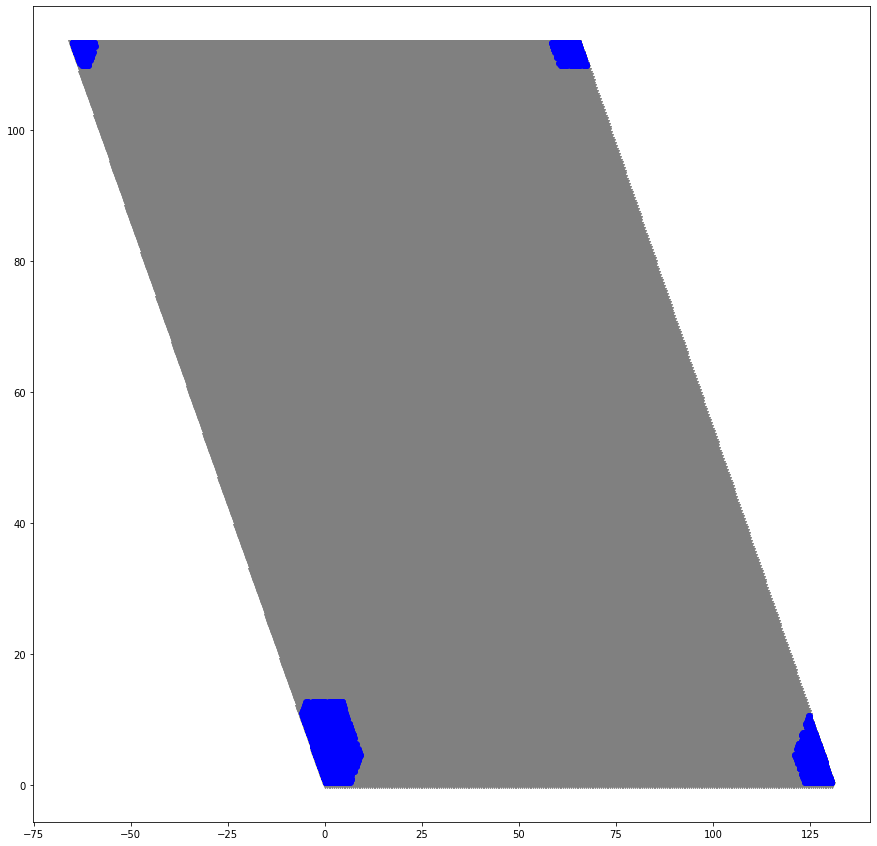

In [7]:
#final walking around, with the PBC working (for the primcell- need to think about expanding to a supercell)
#this is all steps of just a single mesh step - I should probably make sure that it works for larger jumps. 
start=np.random.randint(0,len(x))
traj=[]
#direction_choice=[[1,0],[1/2,np.sqrt(3)/2],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2],[-1,0],[1/2,np.sqrt(3)/2]]
choose_dir    = [[1,0],[1/2,np.sqrt(3)/2],[-1/2,np.sqrt(3)/2],[-1/2,-np.sqrt(3)/2],[-1,0],[1/2,np.sqrt(3)/2]]
#step_size=np.random.randint(-3,3)
steps=[]

R_temp = 5

X_temp = -0.48402500
Y_temp = 4.19177946

PES = []
with open('PES','r') as f3:
    data = f3.readlines()
    for line in data:   
        PES.append([ str(line.split()[0]), 
                     float(line.split()[1]), 
                     float(line.split()[2]), 
                     float(line.split()[3]) ])
        
PES_copy     = copy.deepcopy(PES)


for i in range(1,10000):
     #this is where the new X and Y coords are generated- this is probably where to add the scaling vectors. 
    # we only need three directions to do the trick
    direction_choice1 = choose_dir[0] #this is choosing the direction 
    direction_choice2 = choose_dir[1] 
    direction_choice3 = choose_dir[2] 

    pxy1 = math.ceil( ( 2.0*R_temp)  * ( 2.0*np.random.rand() - 1.0 ) ) # the step-size is cluster size dependent
    pxy2 = math.ceil( ( 2.0*R_temp)  * ( 2.0*np.random.rand() - 1.0 ) ) # the step-size is cluster size dependent
    pxy3 = math.ceil( ( 2.0*R_temp)  * ( 2.0*np.random.rand() - 1.0 ) ) # the step-size is cluster size dependent
    
    X_new = X_temp + direction_choice1[0] *pxy1 * param.xstep_max + direction_choice2[0] *pxy2 * param.xstep_max  + direction_choice3[0] * pxy3 * param.xstep_max#choosing the direction of the step
    Y_new = Y_temp + direction_choice1[1] *pxy1 * param.ystep_max + direction_choice2[1] *pxy2 * param.ystep_max + direction_choice3[1] * pxy3 * param.ystep_max

    
    x_find = X_finder(Y_new, param.primcell_a, param.maxx)       #to make the PBC easier (I think) 

    if ( X_new == X_temp and Y_new == Y_temp ): #no change
        #print("continue!!!")
        continue
            
        # Periodic Boundry Conditions - edited for Al2O3 lattice 
        #do Y PBC first
    if Y_new < param.miny:
        Y_new = param.maxy - param.miny + Y_new
        X_new = (X_new - x_find[0]) + X_finder(Y_new, param.primcell_a,param.maxx)[0]
    elif Y_new > param.maxy:
        Y_new = param.miny - param.maxy + Y_new
        X_new = (X_new - x_find[0]) + X_finder(Y_new, param.primcell_a,param.maxx)[0]

        # X BOUNDARY- need to account for the step size. 
    if X_new < X_finder(Y_new, param.primcell_a, param.maxx)[0]:
        X_new = X_new + X_finder(Y_new,param.primcell_a, param.maxx) [1] -  X_finder(Y_new,param.primcell_a, param.maxx) [0]
    elif X_new > X_finder(Y_new, param.primcell_a, param.maxx)[1]:
        X_new = X_new + X_finder(Y_new,param.primcell_a, param.maxx) [0]  -  X_finder(Y_new,param.primcell_a, param.maxx) [1]

    
    PES_finder(X_new, Y_new,PES_copy, 11 * 11 )
    traj.append([X_new,Y_new])
    
    
trajx=[traj[i][0] for i in range(0,len(traj))]
trajy=[traj[i][1] for i in range(0,len(traj))]

#plot to check the walking around on the grid
plt.figure(figsize=(15,15))
plt.scatter(x,y,marker="v",color="gray")
plt.scatter(trajx,trajy,marker="o",color="blue")

plt.show()

In [13]:
PES_finder(125.362475 ,   4.19177946,PES_copy, 11 * 11 )

125.362475    4.19177946
1: 4.356224999999999 4.19177946
2: 4.5982375 3.7726015100000003
3: 4.840249999999999 3.3534235700000004
4: 0.24201249999999952 2.9342456200000004
5: 0.48402499999999904 2.5150676800000005
6: 0.7260374999999994 2.09588973
7: 0.968049999999999 1.6767117800000002
8: 1.2100624999999994 1.2575338400000002
9: 1.452074999999999 0.8383558900000003
10: 1.6940874999999993 0.41917795000000035
11: 1.9360999999999988 0.0
12: 3.8721999999999994 4.19177946
13: 4.114212499999999 3.7726015100000003
14: 4.356224999999999 3.3534235700000004
15: 4.5982375 2.9342456200000004
16: 4.840249999999999 2.5150676800000005
17: 0.24201249999999952 2.09588973
18: 0.48402499999999904 1.6767117800000002
19: 0.7260374999999994 1.2575338400000002
20: 0.968049999999999 0.8383558900000003
21: 1.2100624999999994 0.41917795000000035
22: 1.452074999999999 0.0
23: 3.3881749999999995 4.19177946
24: 3.6301874999999995 3.7726015100000003
25: 3.8721999999999994 3.3534235700000004
26: 4.114212499999999 2.9

ValueError: Could not find PES for single atom. Bad move! Check you initial setup